In [ ]:
# Импортируем все необходимые библиотеки

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import re
import unicodedata
from typing import Tuple
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Загружаем переменные окружения из .env файла
load_dotenv()

In [ ]:
# Создаем URL для SQLAlchemy
SQLALCHEMY_DATABASE_URL = (
    f"postgresql://"
    f"{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}@"
    f"{os.getenv('POSTGRES_HOST')}:{os.getenv('POSTGRES_PORT')}/"
    f"{os.getenv('POSTGRES_DATABASE')}"
)
engine = create_engine(SQLALCHEMY_DATABASE_URL)

### **Выгрузим три таблицы из базы данных**

1. Таблица `user_data`

```python
# Структура таблицы:
user_data = {
    "user_id": "Уникальный идентификатор пользователя (int64)",
    "gender": "Пол пользователя (int: 0/1)",
    "age": "Возраст пользователя (int32, 0-99)",
    "country": "Страна пользователя (str: 'Russian', 'Belarus', 'Iran', ...)",
    "city": "Город пользователя (str: 'Moscow', 'Abakan', ...)",
    "exp_group": "Экспериментальная группа (int8: 0-4)",
    "os": "Операционная система (str: 'iOS', 'Android', 'web')",
    "source": "Источник привлечения (str: 'ads', ...)"
}
```

2. Таблица `post_text_df`

```python
# Структура таблицы:
post_data = {
    "post_id": "Уникальный ID поста (int64)",
    "text": "Текст поста (str)",
    "topic": "Категория (str: 'politics', 'entertainment', ...)",
}
```

3. Таблица `feed_data`

```python
# Структура таблицы:
feed_data = {
    "user_id": "ID юзера (int64)",
    "post_id": "ID поста (int64)",
    "text": "Текст поста (str)",
    "action": "view/like (str)",
    "timestamp": "Время просмотра поста (timestamp)",
    "target": "0/1 (int64): 1 - если пост был лайкнут в ближайшее время после просмотра (условно в первые 1-2 минуты)",

}
```


In [4]:
# Данные по пользователям

user_info = pd.read_sql("""SELECT * FROM user_data""", con=engine)

user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [5]:
# Посты и топики

posts_info = pd.read_sql("""SELECT * FROM post_text_df""", con=engine)

posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [6]:
# Попробуем забрать, скажем, 5 миллионов

feed_data = pd.read_sql(
    """SELECT * FROM feed_data WHERE action = 'view' LIMIT 5000000""", con=engine
)

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-12-19 13:57:09,125623,1848,view,1
1,2021-12-19 13:59:28,125623,1352,view,0
2,2021-12-25 21:09:37,119570,4806,view,1
3,2021-12-25 21:12:13,119570,4065,view,0
4,2021-12-25 21:14:37,119570,5258,view,0


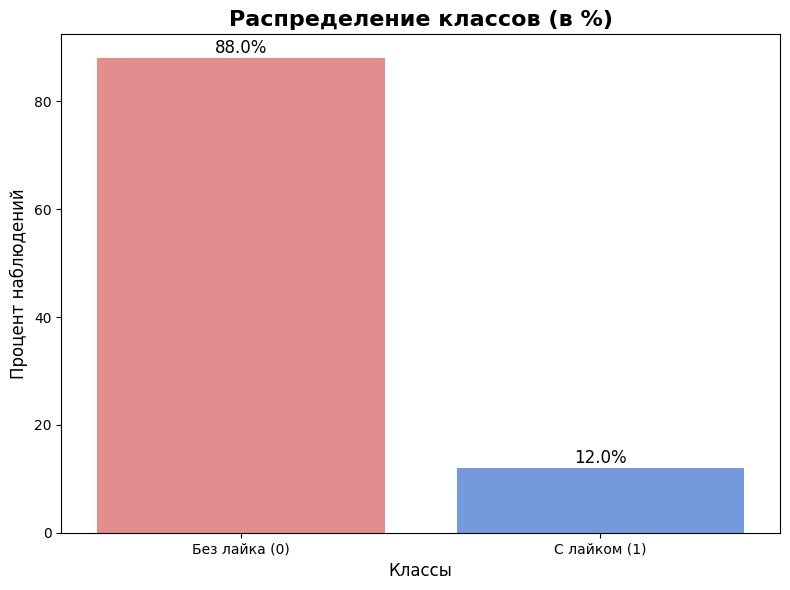

In [ ]:
# Проверяем распределение классов
class_distribution = (
    feed_data["target"].value_counts(normalize=True) * 100
)  # В процентах

# Создаем график
plt.figure(figsize=(8, 6))
sns.barplot(
    x=class_distribution.index,
    y=class_distribution.values,
    palette=["lightcoral", "cornflowerblue"],  # Цвета для классов
)

# Добавляем подписи и заголовок
plt.title("Распределение классов (в %)", fontsize=16, fontweight="bold")
plt.xlabel("Классы", fontsize=12)
plt.ylabel("Процент наблюдений", fontsize=12)
plt.xticks(ticks=[0, 1], labels=["Без лайка (0)", "С лайком (1)"], fontsize=10)

# Добавляем процентные значения над столбцами
for i, value in enumerate(class_distribution):
    plt.text(i, value + 1, f"{value:.1f}%", ha="center", fontsize=12, color="black")

# Отображаем график
plt.tight_layout()
plt.show()

---
**Анализ дисбаланса классов**  

На графике явно виден значительный дисбаланс между классами, что вполне объяснимо с точки зрения поведения пользователей. В реальности пользователи чаще просматривают контент, чем ставят лайки — это естественная особенность взаимодействия с платформой. Такое поведение приводит к тому, что положительный класс (лайки) оказывается значительно менее представленным по сравнению с отрицательным классом (просмотры без лайков).  

Этот дисбаланс необходимо учитывать при разработке модели, чтобы избежать перекоса в сторону большинства и обеспечить качественное предсказание лайков.

Модель может научиться всегда предсказывать "не лайк" и получить искусственно высокую accuracy. Требуется специальная обработка для корректного обучения:
1. Метрики: F1-score, Precision-Recall AUC вместо accuracy
2. Методы: class weighting, oversampling/undersampling
3. Архитектура: ансамблирование или threshold moving

---


## Feature Engineering для таблицы `post_text_df`

### 📌 План генерации признаков

#### 1. Базовые текстовые метрики

**Генерируемые фичи:**

- `text_length` - длина текста в символах
- `word_count` - количество слов в тексте
- `digit_count` - количество цифр в тексте

**Цель:**  
Выявить зависимость между структурой текста и пользовательской вовлеченностью.

---

#### 2. TF-IDF векторизация с предобработкой

**Этапы:**

1. Предобработка текста с помощью spaCy:
   - Лемматизация
   - Удаление стоп-слов
   - Удаление пунктуации/чисел
2. Построение TF-IDF матрицы (10000 наиболее значимых терминов)

**Особенности:**

- Используется русскоязычная модель `ru_core_news_sm`
- Минимальная длина токена - 5 символа

---

#### 3. Агрегатные статистики TF-IDF

**Генерируемые фичи:**

- `tfidf_mean` - среднее значение TF-IDF по терминам
- `tfidf_sum` - сумма значений TF-IDF
- `tfidf_max` - максимальное значение TF-IDF

**Гипотеза:**  
Агрегатные характеристики помогут:

- Оценить общую информативность поста (`mean`)
- Измерить суммарный "вес" ключевых слов (`sum`)
- Выявить доминирующий термин (`max`)

#### PS: В конце поймем, что особо ничего полезного эти фичи не принесли :(

---

#### 4. Снижение размерности

**Метод:** TruncatedSVD (300 компонент)

**Преимущества:**

- Стараемся сохранить как можно больше дисперсии данных
- Уменьшает шумовые компоненты
- Оптимизирует вычислительные затраты для последующей кластеризации

---

#### 5. Кластеризация текстов

**Параметры:**

- Метод: K-Means
- Количество кластеров: 25
- Дополнительные фичи: расстояния до центроидов всех кластеров

**Зачем нужны расстояния:**

- Показывают степень принадлежности к кластерам
- Характеризуют положение поста в признаковом пространстве
- Позволяют выявлять аномальные тексты

---

#### 6. Метрики популярности

**Источник данных:** таблица `feed_data`

**Рассчитываемые показатели:**

- `views` - общее количество просмотров
- `likes` - количество лайков
- `ctr` - коэффициент конверсии (лайки/просмотры)

**Аналитическая ценность:**

- Возможность связать текстовые характеристики с пользовательским engagement
- Выявление "идеального" профиля поста

---


In [8]:
# Загрузка модели spaCy
nlp = spacy.load("en_core_web_sm")


### Функция для предобработки текста
def spacy_preprocess(text: str) -> Tuple[str, int]:
    """
    Очищает текст и унифицирует шрифт:
    - Убирает пунктуацию
    - Группирует числа в один признак (количество чисел)
    - Приводит текст к нижнему регистру
    - Лемматизирует слова
    - Удаляет стоп-слова и короткие слова
    - Унифицирует шрифт (например, убирает стильные шрифты)
    """
    # 1. Унификация шрифта
    text = unicodedata.normalize("NFKC", text)

    # 2. Удаляем HTML-теги и эмодзи
    text = re.sub(r"<[^>]+>", " ", text)  # HTML-теги
    text = re.sub(r"[\U00010000-\U0010ffff]", " ", text)  # Эмодзи

    # 3. Убираем пунктуацию и лишние пробелы
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # 4. Заменяем числа на <NUMBER>
    numbers_count = len(re.findall(r"\d+", text))
    text = re.sub(r"\d+", "<NUMBER>", text)

    # 5. Приводим к нижнему регистру
    text = text.lower()

    # 6. Лемматизация и фильтрация
    doc = nlp(text)
    tokens = [
        token.lemma_
        for token in doc
        if token.is_alpha and not token.is_stop and len(token) > 2
    ]

    return " ".join(tokens), numbers_count

In [9]:
# Применяем spaCy очистку
posts_info["numbers_count"] = posts_info["text"].apply(lambda x: spacy_preprocess(x)[1])
posts_info["cleaned_text"] = posts_info["text"].apply(lambda x: spacy_preprocess(x)[0])

In [10]:
# Функция для подсчета количества слов
def count_words(text):
    if isinstance(text, str):  # Проверяем, что текст не NaN
        words = re.findall(
            r"\b\w+\b", text
        )  # Ищем только слова (без знаков препинания)
        return len(words)
    return 0


# Добавляем новые столбцы
posts_info["text_length"] = posts_info["text"].apply(len)  # Длина текста
posts_info["word_count"] = posts_info["text"].apply(count_words)  # Количество слов

In [11]:
posts_info.head()

,post_id,text,topic,numbers_count,cleaned_text,text_length,word_count
0,1,UK economy facing major risks\n\nThe UK manufa...,business,13,economy face major risk manufacturing sector c...,1967,327
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,20,aid climate davos agenda climate change fight ...,2701,449
2,3,Asian quake hits European shares\n\nShares in ...,business,47,asian quake hit european share share europe le...,3408,571
3,4,India power shares jump on debut\n\nShares in ...,business,6,india power share jump debut share india large...,1026,178
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,3,lacroix label buy firm luxury good group lvmh ...,889,155


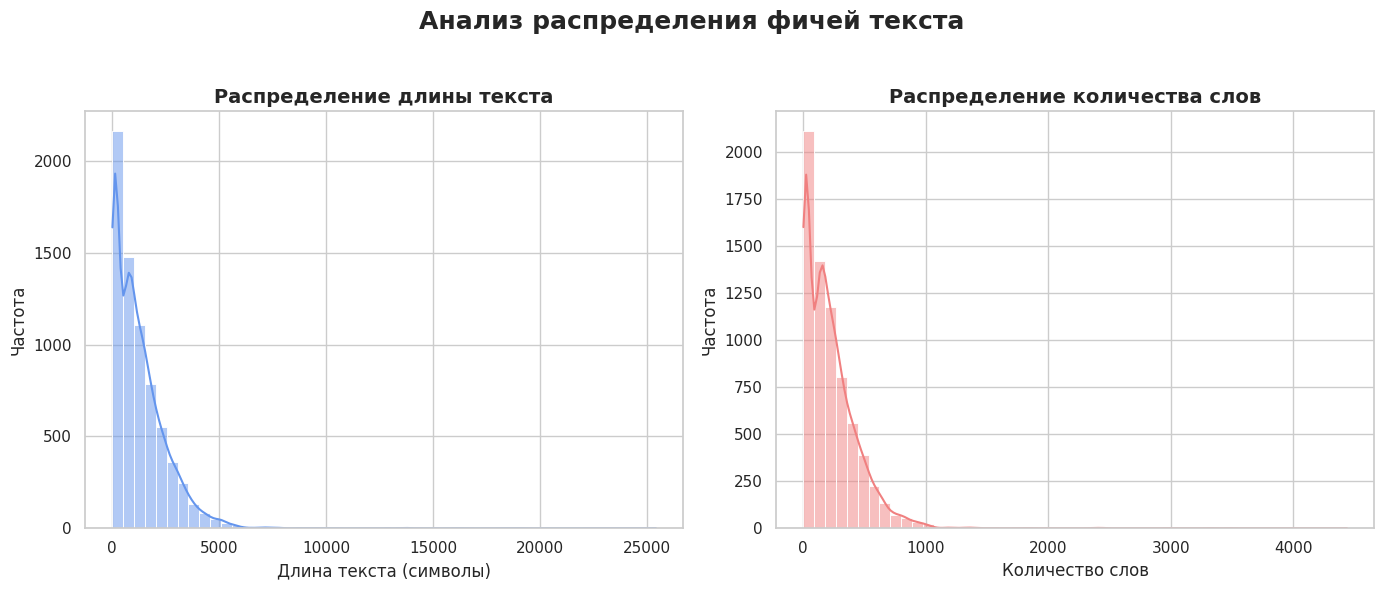

In [ ]:
# Настройка стиля графиков
sns.set(style="whitegrid")

# Создаем фигуру с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График распределения длины текста (text_length)
sns.histplot(
    data=posts_info,
    x="text_length",
    bins=50,
    kde=True,
    color="cornflowerblue",
    ax=axes[0],
)
axes[0].set_title("Распределение длины текста", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Длина текста (символы)", fontsize=12)
axes[0].set_ylabel("Частота", fontsize=12)

# График распределения количества слов (word_count)
sns.histplot(
    data=posts_info, x="word_count", bins=50, kde=True, color="lightcoral", ax=axes[1]
)
axes[1].set_title("Распределение количества слов", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Количество слов", fontsize=12)
axes[1].set_ylabel("Частота", fontsize=12)

# Общий заголовок
fig.suptitle("Анализ распределения фичей текста", fontsize=18, fontweight="bold")

# Отображаем график
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

---

**Анализ распределения фичей**

На графиках видно, что обе фичи — длина текста (text_length) и количество слов (word_count) — демонстрируют логнормальное распределение . Это означает, что большинство текстов имеют небольшую длину и содержат относительно мало слов, в то время как длинные тексты встречаются значительно реже.

Такое поведение типично для пользовательского контента: люди чаще создают короткие сообщения или посты, а длинные тексты являются исключением. Данное наблюдение подчеркивает важность учета выбросов и потенциальной необходимости их нормализации или обработки перед дальнейшим анализом.

---


In [13]:
# TF-IDF векторизация
vectorizer_spacy = TfidfVectorizer(
    max_features=None,  # не ограничивать
    stop_words="english",
    min_df=3,
    max_df=0.95,  # удалим очень частые (шум)
    use_idf=True,
)
tfidf_spacy_matrix = vectorizer_spacy.fit_transform(
    posts_info["cleaned_text"]
).toarray()

# Преобразуем в DataFrame
tfidf_spacy_df = pd.DataFrame(
    tfidf_spacy_matrix, columns=vectorizer_spacy.get_feature_names_out()
)
tfidf_spacy_df["post_id"] = posts_info["post_id"].values  # добавим идентификатор

tfidf_spacy_df.head()

,aaa,aaas,aamir,aaron,abandon,abandonment,abate,abba,abbas,abbasi,...,zola,zombi,zombie,zone,zoo,zoom,zucco,zucker,zurich,post_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074193,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051226,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5


In [14]:
### Генерим фичи на основе TfIdf (возьмем сначала простую агрегацию)
posts_info["TotalTfIdf"] = (
    tfidf_spacy_df.drop(columns=["post_id", "topic"], axis=1)
    .sum(axis=1)
    .reset_index()[0]
)
posts_info["MaxTfIdf"] = (
    tfidf_spacy_df.drop(columns=["post_id", "topic"], axis=1)
    .max(axis=1)
    .reset_index()[0]
)
posts_info["MeanTfIdf"] = (
    tfidf_spacy_df.drop(columns=["post_id", "topic"], axis=1)
    .mean(axis=1)
    .reset_index()[0]
)

posts_info.head()

,post_id,text,topic,numbers_count,cleaned_text,text_length,word_count,TotalTfIdf,MaxTfIdf,MeanTfIdf
0,1,UK economy facing major risks\n\nThe UK manufa...,business,13,economy face major risk manufacturing sector c...,1967,327,8.134297,0.511790,0.000541
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,20,aid climate davos agenda climate change fight ...,2701,449,11.356141,0.254945,0.000756
2,3,Asian quake hits European shares\n\nShares in ...,business,47,asian quake hit european share share europe le...,3408,571,10.911138,0.410319,0.000726
3,4,India power shares jump on debut\n\nShares in ...,business,6,india power share jump debut share india large...,1026,178,6.754817,0.372043,0.000450
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,3,lacroix label buy firm luxury good group lvmh ...,889,155,5.946105,0.526337,0.000396


In [15]:
### Снизим размерность TF-IDF матрицы
centered = tfidf_spacy_matrix - tfidf_spacy_matrix.mean()

# TruncatedSVD
svd = TruncatedSVD(n_components=300, random_state=42)
svd_decomp = svd.fit_transform(centered)

In [16]:
### Кластеризация по семантике
kmeans = KMeans(n_clusters=25, random_state=42)
cluster = kmeans.fit_predict(svd_decomp).reshape(-1, 1)
posts_info["TextCluster"] = cluster

# Генерация названий столбцов динамически
num_clusters = 25  # Количество кластеров
dists_columns = [
    f"DistanceTo{cluster}thCluster" for cluster in range(1, num_clusters + 1)
]

# Создание DataFrame с автоматически сгенерированными названиями столбцов
dists_df = pd.DataFrame(data=kmeans.transform(svd_decomp), columns=dists_columns)

# Проверка первых строк
dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,...,DistanceTo16thCluster,DistanceTo17thCluster,DistanceTo18thCluster,DistanceTo19thCluster,DistanceTo20thCluster,DistanceTo21thCluster,DistanceTo22thCluster,DistanceTo23thCluster,DistanceTo24thCluster,DistanceTo25thCluster
0,0.620717,0.639040,0.710284,0.592390,0.703258,0.632899,0.942256,0.635237,0.436462,0.761016,...,0.828193,0.757815,0.671149,0.611784,0.581796,0.584506,0.587526,0.540042,0.624294,0.702854
1,0.609376,0.632340,0.684434,0.589731,0.675975,0.621455,0.916474,0.558346,0.516970,0.739384,...,0.820065,0.728541,0.661025,0.587971,0.557299,0.577983,0.579828,0.512105,0.646764,0.703910
2,0.725162,0.744982,0.766279,0.701997,0.740468,0.729460,1.024672,0.754167,0.509004,0.814646,...,0.901114,0.803224,0.772441,0.668490,0.658415,0.700094,0.685362,0.642903,0.629109,0.773713
3,0.714635,0.730692,0.802663,0.705589,0.798022,0.725473,1.013979,0.732404,0.621708,0.843584,...,0.859086,0.837872,0.749451,0.716179,0.683872,0.682313,0.680886,0.633085,0.789145,0.804049
4,0.531889,0.549947,0.657950,0.520446,0.659838,0.542882,0.898131,0.574709,0.528084,0.704511,...,0.762391,0.708491,0.591135,0.554863,0.506563,0.484730,0.524628,0.448073,0.686375,0.635861


In [17]:
posts_info = pd.concat((posts_info, dists_df), axis=1).drop(
    columns=["cleaned_text"], axis=1
)

In [18]:
post_statistics = pd.read_sql(
    """
    WITH prep AS (
        SELECT
            timestamp,
            user_id,
            post_id,
            action,
            target,
            MIN(timestamp) FILTER (WHERE target = 1) OVER (PARTITION BY user_id, post_id) AS min_timestamp,
            CASE
                WHEN timestamp > MIN(timestamp) FILTER (WHERE target = 1) OVER (PARTITION BY user_id, post_id)
                THEN 1
                ELSE 0
            END AS check
        FROM feed_data
        WHERE action <> 'like'
    )
    SELECT
        post_id,
        COUNT(*) FILTER (WHERE target = 0) AS total_views_post,
        COUNT(*) FILTER (WHERE target = 1) AS total_likes_post,
        COUNT(*) FILTER (WHERE target = 1) * 1.0 / NULLIF(COUNT(*), 0) AS post_ctr
    FROM prep
    WHERE "check" = 0
    GROUP BY post_id
    """,
    con=engine,
)

# Заполняем медианами
views_median = post_statistics["total_views_post"].median()
likes_median = post_statistics["total_likes_post"].median()

post_statistics["total_views_post"].fillna(views_median, inplace=True)
post_statistics["total_likes_post"].fillna(likes_median, inplace=True)

# Пересчитываем CTR
post_statistics["post_ctr"] = (
    post_statistics["total_likes_post"] / post_statistics["total_views_post"]
)

post_statistics.head()

,post_id,total_views_post,total_likes_post,post_ctr
0,1,7414,1057,0.142568
1,2,6851,636,0.092833
2,3,7263,1116,0.153656
3,4,6964,1165,0.167289
4,5,7400,1141,0.154189


In [20]:
# Соединяем нашу таблицу со статистическими признаками

posts_info = posts_info.join(
    post_statistics.set_index("post_id"), on="post_id", how="left"
)

posts_info.head()

,post_id,text,topic,numbers_count,text_length,word_count,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,...,DistanceTo19thCluster,DistanceTo20thCluster,DistanceTo21thCluster,DistanceTo22thCluster,DistanceTo23thCluster,DistanceTo24thCluster,DistanceTo25thCluster,total_views_post,total_likes_post,post_ctr
0,1,UK economy facing major risks\n\nThe UK manufa...,business,13,1967,327,8.134297,0.511790,0.000541,8,...,0.611784,0.581796,0.584506,0.587526,0.540042,0.624294,0.702854,7414,1057,0.142568
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,20,2701,449,11.356141,0.254945,0.000756,22,...,0.587971,0.557299,0.577983,0.579828,0.512105,0.646764,0.703910,6851,636,0.092833
2,3,Asian quake hits European shares\n\nShares in ...,business,47,3408,571,10.911138,0.410319,0.000726,8,...,0.668490,0.658415,0.700094,0.685362,0.642903,0.629109,0.773713,7263,1116,0.153656
3,4,India power shares jump on debut\n\nShares in ...,business,6,1026,178,6.754817,0.372043,0.000450,8,...,0.716179,0.683872,0.682313,0.680886,0.633085,0.789145,0.804049,6964,1165,0.167289
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,3,889,155,5.946105,0.526337,0.000396,22,...,0.554863,0.506563,0.484730,0.524628,0.448073,0.686375,0.635861,7400,1141,0.154189


In [21]:
# Загружаем таблица со всеми признаками постов в базу данных

posts_info.to_sql(
    "posts_info_features_ruslan_prashchurovich",
    con=engine,
    index=False,
    if_exists="replace",
)

143

In [22]:
# Функция для пакетной загрузки данных из SQL
def batch_load_sql(query: str, engine) -> pd.DataFrame:
    CHUNKSIZE = 200000
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)


# Функция для загрузки признаков из базы данных
def load_posts_features(engine) -> pd.DataFrame:
    query = "SELECT * FROM posts_info_features_ruslan_prashchurovich"
    return batch_load_sql(query, engine)


# Проверка загрузки данных
post_features = load_posts_features(engine)
post_features.head()

,post_id,text,topic,numbers_count,text_length,word_count,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,...,DistanceTo19thCluster,DistanceTo20thCluster,DistanceTo21thCluster,DistanceTo22thCluster,DistanceTo23thCluster,DistanceTo24thCluster,DistanceTo25thCluster,total_views_post,total_likes_post,post_ctr
0,1,UK economy facing major risks\n\nThe UK manufa...,business,13,1967,327,8.134297,0.511790,0.000541,8,...,0.611784,0.581796,0.584506,0.587526,0.540042,0.624294,0.702854,7414,1057,0.142568
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,20,2701,449,11.356141,0.254945,0.000756,22,...,0.587971,0.557299,0.577983,0.579828,0.512105,0.646764,0.703910,6851,636,0.092833
2,3,Asian quake hits European shares\n\nShares in ...,business,47,3408,571,10.911138,0.410319,0.000726,8,...,0.668490,0.658415,0.700094,0.685362,0.642903,0.629109,0.773713,7263,1116,0.153656
3,4,India power shares jump on debut\n\nShares in ...,business,6,1026,178,6.754817,0.372043,0.000450,8,...,0.716179,0.683872,0.682313,0.680886,0.633085,0.789145,0.804049,6964,1165,0.167289
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,3,889,155,5.946105,0.526337,0.000396,22,...,0.554863,0.506563,0.484730,0.524628,0.448073,0.686375,0.635861,7400,1141,0.154189


In [23]:
# Почистим переменные

del svd
del KMeans
del spacy_preprocess

del tfidf_spacy_matrix
del tfidf_spacy_df
del centered
del svd_decomp
del kmeans
del dists_columns
del dists_df

import gc

gc.collect()

728

## Feature Engineering для таблицы `user_data`

### 📝 План генерации признаков пользователей

#### 1. Возрастные группы

**Генерируемые фичи:**

- `age_group` (категориальный признак)

**Группировка:**

- `child`: 0-18 лет
- `young`: 18-35 лет
- `middle_aged`: 35-50 лет
- `senior`: 50+ лет

**Гипотеза:**  
Разные возрастные группы демонстрируют различное поведение при взаимодействии с контентом. Например:

- Молодежь более активна с коротким форматом
- Старшая возрастная группа предпочитает более сложный контент

---

#### 2. Показатели активности пользователя

**Источник данных:** таблицы `feed_data` + `post_text_df`

**Генерируемые фичи:**

- `user_total_views` - общее количество просмотров
- `user_total_likes` - общее количество лайков
- `user_ctr` - отношение лайков к просмотрам (лайки/просмотры)
- `favorite_topic` - самая частая тема лайкнутых постов
- `mean_length_view` - средняя длина просмотренных текстов
- `mean_length_number_view` - среднее количество цифр в просмотренных текстах
- `mean_length_like` - средняя длина лайкнутых текстов
- `mean_length_number_like` - среднее количество цифр в лайкнутых текстах

**Гипотезы:**

| Признак                   | Гипотеза                                          | Ожидаемый эффект                                         |
| ------------------------- | ------------------------------------------------- | -------------------------------------------------------- |
| `user_ctr`                | Пользователи с высоким CTR более избирательны     | Поможет выделить "качественную" аудиторию                |
| `mean_length_view`        | Пользователи имеют предпочтения по длине контента | Позволит персонализировать рекомендации по объему текста |
| `mean_length_like`        | Лайкают посты определенной длины                  | Выявит оптимальную длину контента для вовлечения         |
| `mean_length_number_view` | Цифры в тексте привлекают внимание                | Поможет определить интерес к аналитическому контенту     |
| `favorite_topic`          | У пользователей есть тематические предпочтения    | Улучшит тематическую персонализацию                      |


In [ ]:
# Определяем функцию для категоризации возраста
def categorize_age(age):
    if age < 18:
        return "child"
    elif 18 <= age < 35:
        return "young"
    elif 35 <= age < 50:
        return "middle_aged"
    else:
        return "senior"


# Применяем функцию к столбцу age
user_info["age_category"] = user_info["age"].apply(categorize_age)
user_info = user_info.drop(columns=["age"], axis=1)
user_info.head()

In [ ]:
# Поскольку таблица очень большая, посчитаем все метрики прям в БД

users_statistics = pd.read_sql(
    """
    WITH prep AS (
        SELECT
            timestamp,
            user_id,
            post_id,
            action,
            target,
            MIN(timestamp) FILTER (WHERE target = 1) OVER (PARTITION BY user_id, post_id) AS min_timestamp,
            CASE
                WHEN timestamp > MIN(timestamp) FILTER (WHERE target = 1) OVER (PARTITION BY user_id, post_id)
                THEN 1
                ELSE 0
            END AS check
        FROM feed_data
        WHERE action <> 'like'
    )
    SELECT
        user_id,
        COUNT(*) FILTER (WHERE target = 0) AS user_total_views,
        COUNT(*) FILTER (WHERE target = 1) AS user_total_likes,
        COUNT(*) FILTER (WHERE target = 1) * 1.0 / NULLIF(COUNT(*), 0) AS user_ctr
    FROM prep
    WHERE "check" = 0
    GROUP BY user_id
    """,
    con=engine,
)
users_statistics.head()

In [ ]:
# Найдем для каждого пользователя его любимый топик по следующей логике:
# - посчитаем для каждого пользователя для каждого поста кол-во просмотров, лайков, ctr
# - взвесим все три показателя

user_favorite_topic = pd.read_sql(
    """
    WITH prep AS (
        SELECT
            timestamp,
            user_id,
            post_id,
            action,
            target,
            MIN(timestamp) FILTER (WHERE target = 1) OVER (PARTITION BY user_id, post_id) AS min_timestamp,
            CASE
                WHEN timestamp > MIN(timestamp) FILTER (WHERE target = 1) OVER (PARTITION BY user_id, post_id)
                THEN 1
                ELSE 0
            END AS check
        FROM feed_data
        WHERE action <> 'like'
    ),
    grouped AS (
        SELECT
            user_id,
            topic,
            COUNT(*) FILTER (WHERE target = 0) AS user_total_views,
            COUNT(*) FILTER (WHERE target = 1) AS user_total_likes,
            COUNT(*) FILTER (WHERE target = 1) * 1.0 / NULLIF(COUNT(*), 0) AS user_ctr
        FROM prep
        INNER JOIN post_text_df ON prep.post_id = post_text_df.post_id
        WHERE "check" = 0
        GROUP BY user_id, topic
    ),
    normalized AS (
        SELECT
            user_id,
            topic,
            (user_total_likes - MIN(user_total_likes) OVER ()) 
                                                    / NULLIF((MAX(user_total_likes) OVER () - MIN(user_total_likes) OVER ()), 0) AS normalized_likes,
            (user_total_views - MIN(user_total_views) OVER ())
                                                    / NULLIF((MAX(user_total_views) OVER () - MIN(user_total_views) OVER ()), 0) AS normalized_views,
            (user_ctr - MIN(user_ctr) OVER ()) / NULLIF((MAX(user_ctr) OVER () - MIN(user_ctr) OVER ()), 0) AS normalized_ctr
        FROM grouped
    ),
    combined_scores AS (
        SELECT
            user_id,
            topic,
            0.4 * normalized_likes + 0.3 * normalized_views + 0.3 * normalized_ctr AS combined_score
        FROM normalized
    ),
    ranked_topics AS (
        SELECT
            user_id,
            topic,
            combined_score,
            ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY combined_score DESC) AS rank
        FROM combined_scores
    )
    SELECT
        user_id,
        topic AS favorite_topic,
        combined_score
    FROM ranked_topics
    WHERE rank = 1;
    """,
    con=engine,
)

# Вывод результата
user_favorite_topic.head()

In [ ]:
user_info = user_info.join(
    users_statistics.set_index("user_id"), on="user_id", how="left"
)
user_info = user_info.join(
    user_favorite_topic.set_index("user_id").drop(columns=["combined_score"], axis=1),
    on="user_id",
    how="left",
)
user_info.head()

In [ ]:
# Также найдем любимый час для лайка

user_favorite_hour = pd.read_sql(
    """
    WITH prep AS (
        SELECT
            timestamp,
            user_id,
            post_id,
            action,
            target,
            MIN(timestamp) FILTER (WHERE target = 1) OVER (PARTITION BY user_id, post_id) AS min_timestamp,
            CASE
                WHEN timestamp > MIN(timestamp) FILTER (WHERE target = 1) OVER (PARTITION BY user_id, post_id)
                THEN 1
                ELSE 0
            END AS check
        FROM feed_data
        WHERE action <> 'like'
    ),
    grouped AS (
        SELECT
            user_id,
            EXTRACT(HOUR FROM timestamp) AS hour_of_day,
            COUNT(*) FILTER (WHERE target = 0) AS total_views,
            COUNT(*) FILTER (WHERE target = 1) AS total_likes,
            COUNT(*) FILTER (WHERE target = 1) * 1.0 / NULLIF(COUNT(*), 0) AS ctr
        FROM prep
        WHERE "check" = 0
        GROUP BY user_id, EXTRACT(HOUR FROM timestamp)
    ),
    normalized AS (
        SELECT
            user_id,
            hour_of_day,
            (total_likes - MIN(total_likes) OVER ()) / NULLIF((MAX(total_likes) OVER () - MIN(total_likes) OVER ()), 0) AS normalized_likes,
            (total_views - MIN(total_views) OVER ()) / NULLIF((MAX(total_views) OVER () - MIN(total_views) OVER ()), 0) AS normalized_views,
            (ctr - MIN(ctr) OVER ()) / NULLIF((MAX(ctr) OVER () - MIN(ctr) OVER ()), 0) AS normalized_ctr
        FROM grouped
    ),
    combined_scores AS (
        SELECT
            user_id,
            hour_of_day,
            0.35 * normalized_likes + 0.15 * normalized_views + 0.5 * normalized_ctr AS combined_score
        FROM normalized
    ),
    ranked_hours AS (
        SELECT
            user_id,
            hour_of_day,
            combined_score,
            ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY combined_score DESC) AS rank
        FROM combined_scores
    )
    SELECT
        user_id,
        hour_of_day AS favorite_hour,
        combined_score
    FROM ranked_hours
    WHERE rank = 1;
    """,
    con=engine,
)
user_favorite_hour.head()

In [ ]:
# Также попробуем посчитать среднюю длину текста, которые пользователи любят смотреть и лайкать

user_post_length = pd.read_sql(
    """
    WITH post_stats AS (
        SELECT
            post_id,
            LENGTH(text) AS text_length,
            (LENGTH(text) - LENGTH(REGEXP_REPLACE(text, '[0-9]', '', 'g'))) AS number_count
        FROM post_text_df
    ),
    user_actions AS (
        SELECT
            user_id,
            post_id,
            action,
            target
        FROM feed_data
        WHERE action <> 'like'
    ),
    aggregated_stats AS (
        SELECT
            ua.user_id,
            AVG(ps.text_length) FILTER (WHERE ps.post_id IS NOT NULL) AS avg_text_length_all,
            AVG(ps.number_count) FILTER (WHERE ps.post_id IS NOT NULL) AS avg_number_count_all,
            AVG(ps.text_length) FILTER (WHERE ua.target = 1) AS avg_text_length_liked,
            AVG(ps.number_count) FILTER (WHERE ua.target = 1) AS avg_number_count_liked,
            AVG(ps.text_length) FILTER (WHERE ua.target = 0) AS avg_text_length_viewed_only,
            AVG(ps.number_count) FILTER (WHERE ua.target = 0) AS avg_number_count_viewed_only
        FROM user_actions ua
        LEFT JOIN post_stats ps ON ua.post_id = ps.post_id
        GROUP BY ua.user_id
    )
    SELECT
        user_id,
        avg_text_length_all,
        avg_number_count_all,
        avg_text_length_liked,
        avg_number_count_liked,
        avg_text_length_viewed_only,
        avg_number_count_viewed_only
    FROM aggregated_stats;
    """,
    con=engine,
)

user_post_length.head()

In [ ]:
user_info = user_info.join(
    user_post_length.set_index("user_id"), on="user_id", how="left"
)

In [ ]:
# Загружаем таблица со всеми признаками юзеров в базу данных

user_info.to_sql(
    "users_info_features_ruslan_prashchurovich",
    con=engine,
    index=False,
    if_exists="replace",
)

In [ ]:
# Функция для загрузки признаков юзеров из базы данных
def load_users_features(engine) -> pd.DataFrame:
    query = "SELECT * FROM users_info_features_ruslan_prashchurovich"
    return batch_load_sql(query, engine)


# Проверка загрузки данных
users_features = load_users_features(engine)
users_features.head()